In [38]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.family"] = "serif"
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
import xgboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline


In [17]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
tornados = [read_merged("tornado", year) for year in range(2015, 2024)]
data = pd.concat(tornados)
del tornados
del data['Unnamed: 0'], data['Event Month']
#data['DATE'] = pd.to_datetime(data['DATE'])
#data['Month'] = data['DATE'].dt.month

/tmp/ipykernel_18779/750022928.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [13]:
newnames = {'LAT_mean':'LAT', 'LON_mean':'LON', 'AVGDV_max':'AVGDV', 'LLDV_max':'LLDV', 'MXDV_max':'MXDV', 'MXDV_HEIGHT_max':'MXDV_HEIGHT', 'DEPTH_max':'DEPTH', 'MAX_SHEAR_max':'MAX_SHEAR', 'MAX_SHEAR_HEIGHT_max':'MAX_SHEAR_HEIGHT',
           'county':'COUNTY', 'state':'STATE', 'Month':'MONTH', 'power_outage':'POWER_OUTAGE'}
data_n = data.copy()
data_n = data_n.rename(columns=newnames)
data_n.head()

,DATE,LAT,LON,AVGDV,LLDV,MXDV,MXDV_HEIGHT,DEPTH,MAX_SHEAR,MAX_SHEAR_HEIGHT,COUNTY,STATE,MONTH,POWER_OUTAGE
0,2015-01-01,29.883422,-95.018742,60.0,89.0,89.0,7.0,40.8,35.0,25.0,Harris County,Texas,1,False
1,2015-01-01,30.301864,-95.169685,76.0,102.0,102.0,19.0,51.1,152.0,18.6,Montgomery County,Texas,1,False
2,2015-01-01,30.578940,-95.494050,53.0,71.0,71.0,1.0,10.5,37.0,1.0,Walker County,Texas,1,False
3,2015-01-01,30.440490,-94.827880,51.0,66.0,97.0,18.0,16.0,37.0,18.0,San Jacinto County,Texas,1,False
4,2015-01-01,30.141685,-95.222725,47.0,57.0,74.0,7.0,6.5,62.0,6.9,Montgomery County,Texas,1,False


In [23]:
tor_train, tor_test = train_test_split(data, test_size=0.2, stratify=data.POWER_OUTAGE, random_state=5)
tor_tt, tor_val = train_test_split(tor_train, test_size=0.2, stratify=tor_train.POWER_OUTAGE, random_state=5)
#tor_train_n, tor_test_n = train_test_split(data_n, test_size=0.2, stratify=data.power_outage, random_state=5)
#tor_tt_n, tor_val_n = train_test_split(tor_train_n, test_size=0.2, stratify=tor_train.power_outage, random_state=5)
outage = tor_tt[tor_tt['POWER_OUTAGE']==True]
no_outage = tor_tt[tor_tt['POWER_OUTAGE']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced_tt = pd.concat([outage,no_outage],axis=0)

In [83]:
data_n.columns

Index(['DATE', 'LAT', 'LON', 'AVGDV', 'LLDV', 'MXDV', 'MXDV_HEIGHT', 'DEPTH',
       'NAX_SHEAR', 'MAX_SHEAR_HEIGHT', 'COUNTY', 'STATE', 'MONTH',
       'POWER_OUTAGE', 'Event Month'],
      dtype='object')

In [24]:
features = ['LAT', 'LON', 'AVGDV', 'LLDV', 'MXDV', 'MONTH']
features_n = ['MONTH', 'LAT', 'LON', 'AVGDV', 'LLDV', 'MXDV', 'MXDV_HEIGHT', 'DEPTH', 'MAX_SHEAR', 'MAX_SHEAR_HEIGHT']

## If not saved

In [27]:
xgb_clf = xgboost.XGBClassifier(objective= 'binary:logistic', learning_rate=0.01, max_depth=12, n_estimators=440)
rf_clf =  RandomForestClassifier(n_estimators=300, max_depth=13)
#logistic_clf = Pipeline([('scaler',StandardScaler()), ('logistic', LogisticRegression(C=0.1))])
knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(13))])
models = {'xgboost_v2':xgb_clf, 'RandomForest_v2':rf_clf, 'knn':knn}
for name, model in models.items():
    model.fit(balanced_tt[features], balanced_tt['POWER_OUTAGE'])
    joblib.dump(model,'../../models/{}_tornado.pkl'.format(name))
    

## If saved

In [29]:
xgb = joblib.load('../../models/xgb_tornado.pkl')
rf = joblib.load('../../models/rf_tornado.pkl')
sgd = joblib.load('../../models/sgd_tornado.pkl')
svc = joblib.load('../../models/svc_tornado.pkl')
xgb_y = joblib.load('../../models/xgboost_v2_tornado.pkl')
rf_h = joblib.load('../../models/RandomForest_v2_tornado.pkl')
knn = joblib.load('../../models/knn_tornado.pkl')
xgb_rf_sgd_svc_tornado = joblib.load('../../models/xgb_rf_sgd_svc_tornado.pkl')

In [30]:
models = {'xgboost':xgb, 'RandomForest':rf, 'xgboost_v2': xgb_y,'RandomForest_v2': rf_h, 'StochasticGD': sgd, 'SVM':svc, 'Ensemble':xgb_rf_sgd_svc_tornado, 'knn':knn}

In [31]:
precisions, recalls, predictions = {}, {}, {}

In [33]:
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'knn':
        preds = model.predict(tor_val[features])
        predictions[name] = preds
        recalls[name] = recall_score(tor_val['POWER_OUTAGE'], preds)
        precisions[name] = precision_score(tor_val['POWER_OUTAGE'], preds)
        
    else:
        preds = model.predict(tor_val[features_n])
        predictions[name] = preds
        precisions[name] = precision_score(tor_val['POWER_OUTAGE'], preds)
        recalls[name] = recall_score(tor_val['POWER_OUTAGE'], preds)



In [34]:
for name in models:
    print(f"Precision for {name} is {precisions[name]}")
    print(f"Recall for {name} is {recalls[name]}")

Precision for xgboost is 0.16530176863257862
Recall for xgboost is 0.8992886559341071
Precision for RandomForest is 0.15633727889346988
Recall for RandomForest is 0.8801946836390865
Precision for xgboost_v2 is 0.14804469273743018
Recall for xgboost_v2 is 0.8333957319356047
Precision for RandomForest_v2 is 0.14050406826751338
Recall for RandomForest_v2 is 0.7952077873455634
Precision for StochasticGD is 0.06517393042782887
Recall for StochasticGD is 0.6712841632347435
Precision for SVM is 0.06569034440344404
Recall for SVM is 0.6398352676900038
Precision for Ensemble is 0.14376970971132855
Recall for Ensemble is 0.6656682890303257
Precision for knn is 0.10719131614654002
Recall for knn is 0.7985773118682141


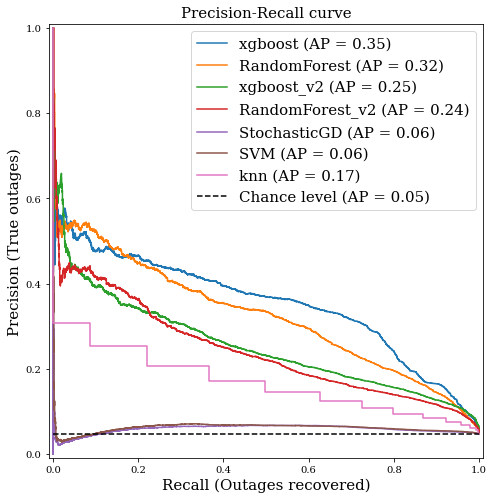

In [37]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(12, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'knn':
        display = PrecisionRecallDisplay.from_estimator(
        model, tor_val[features], tor_val['POWER_OUTAGE'], plot_chance_level=name=='knn', 
            ax=ax, name=name)
    elif name != 'Ensemble':
        display = PrecisionRecallDisplay.from_estimator(
        model, tor_val[features_n], tor_val['POWER_OUTAGE'], 
            ax=ax, name=name)
    #display.plot(ax=ax, name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      

plt.savefig("../../figures/tornados_model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)


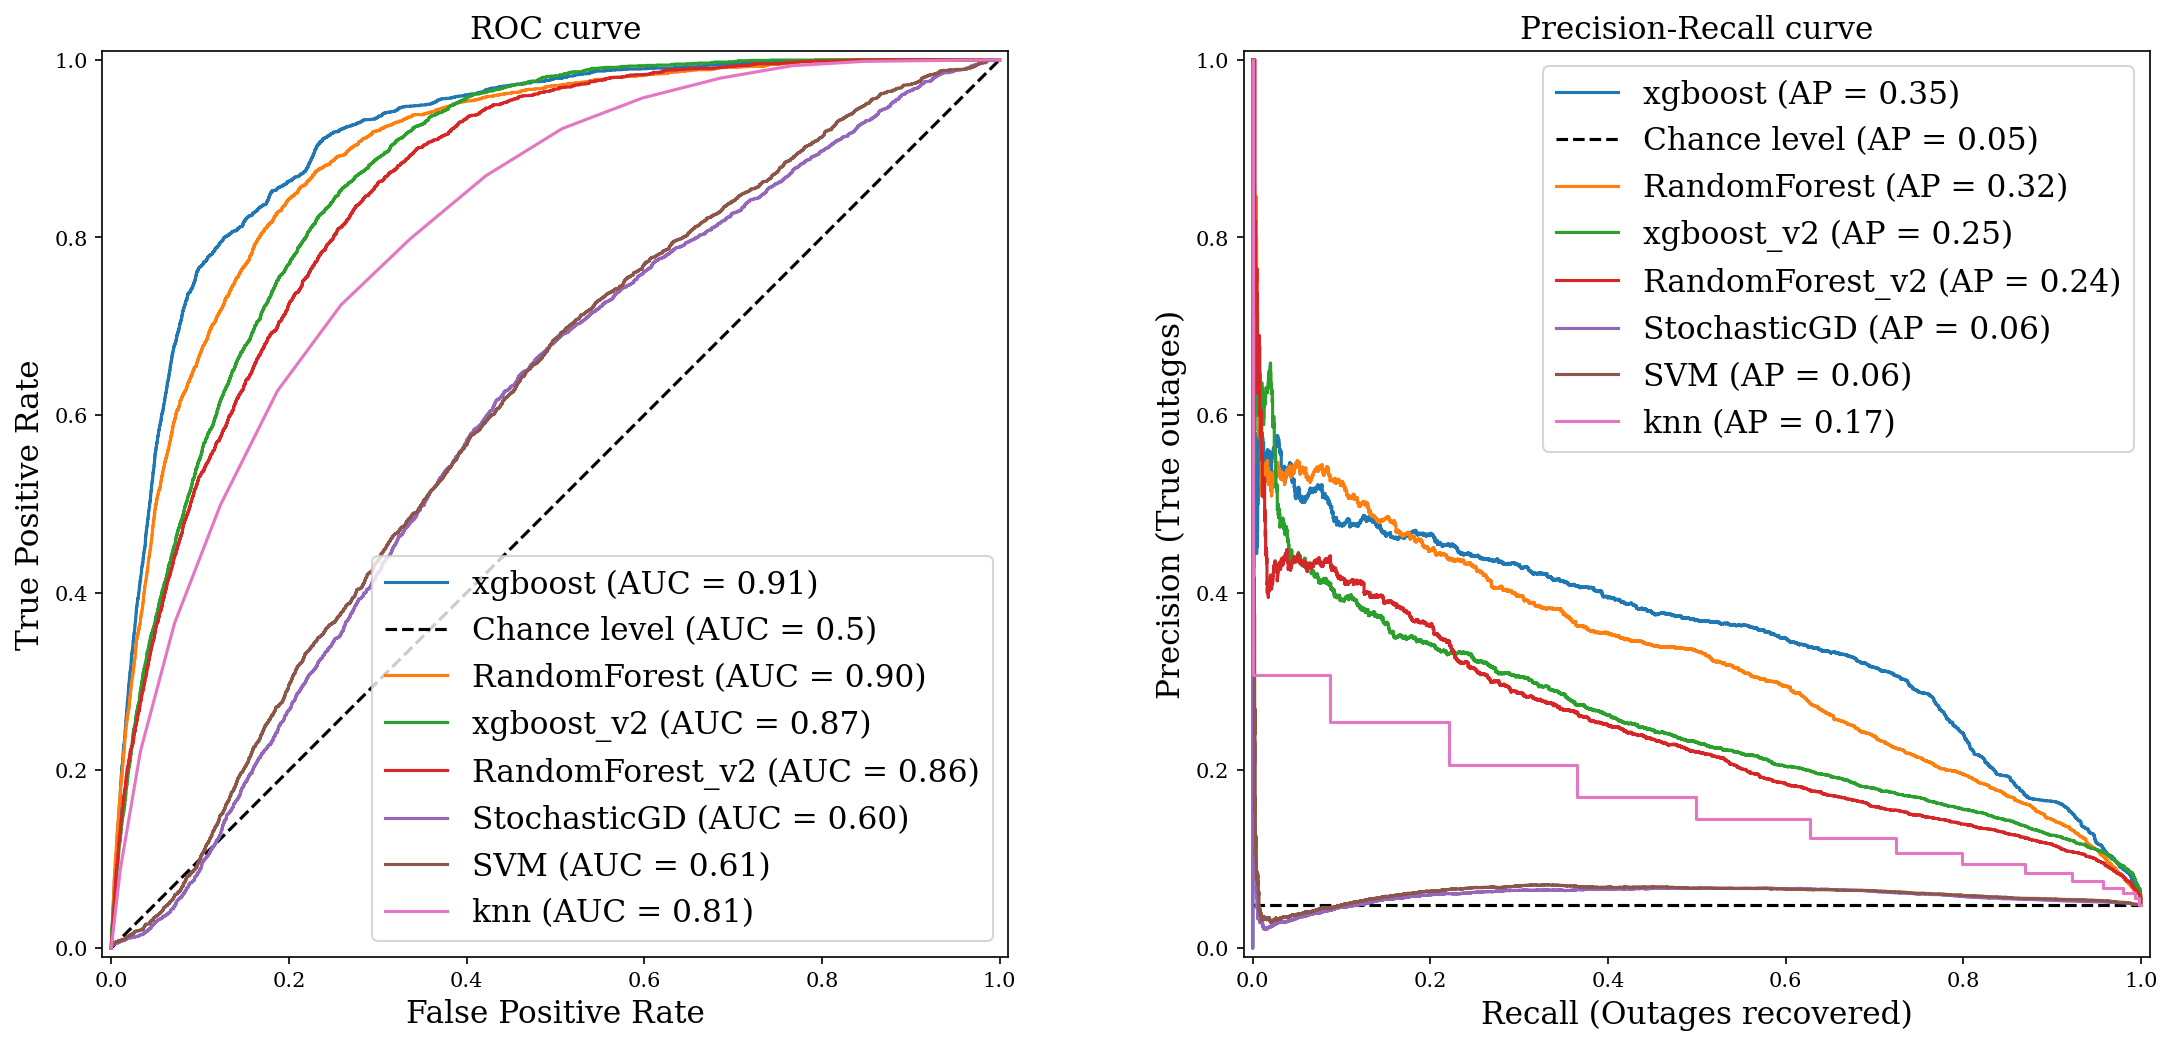

In [62]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'knn':
        display = PrecisionRecallDisplay.from_estimator(
        model, tor_val[features], tor_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, tor_val[features], tor_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
    elif name != 'Ensemble':
        display = PrecisionRecallDisplay.from_estimator(
        model, tor_val[features_n], tor_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, tor_val[features_n], tor_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/tornado_roc_pr_model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)



# Results on test 

In [43]:
best_model = models['xgboost']

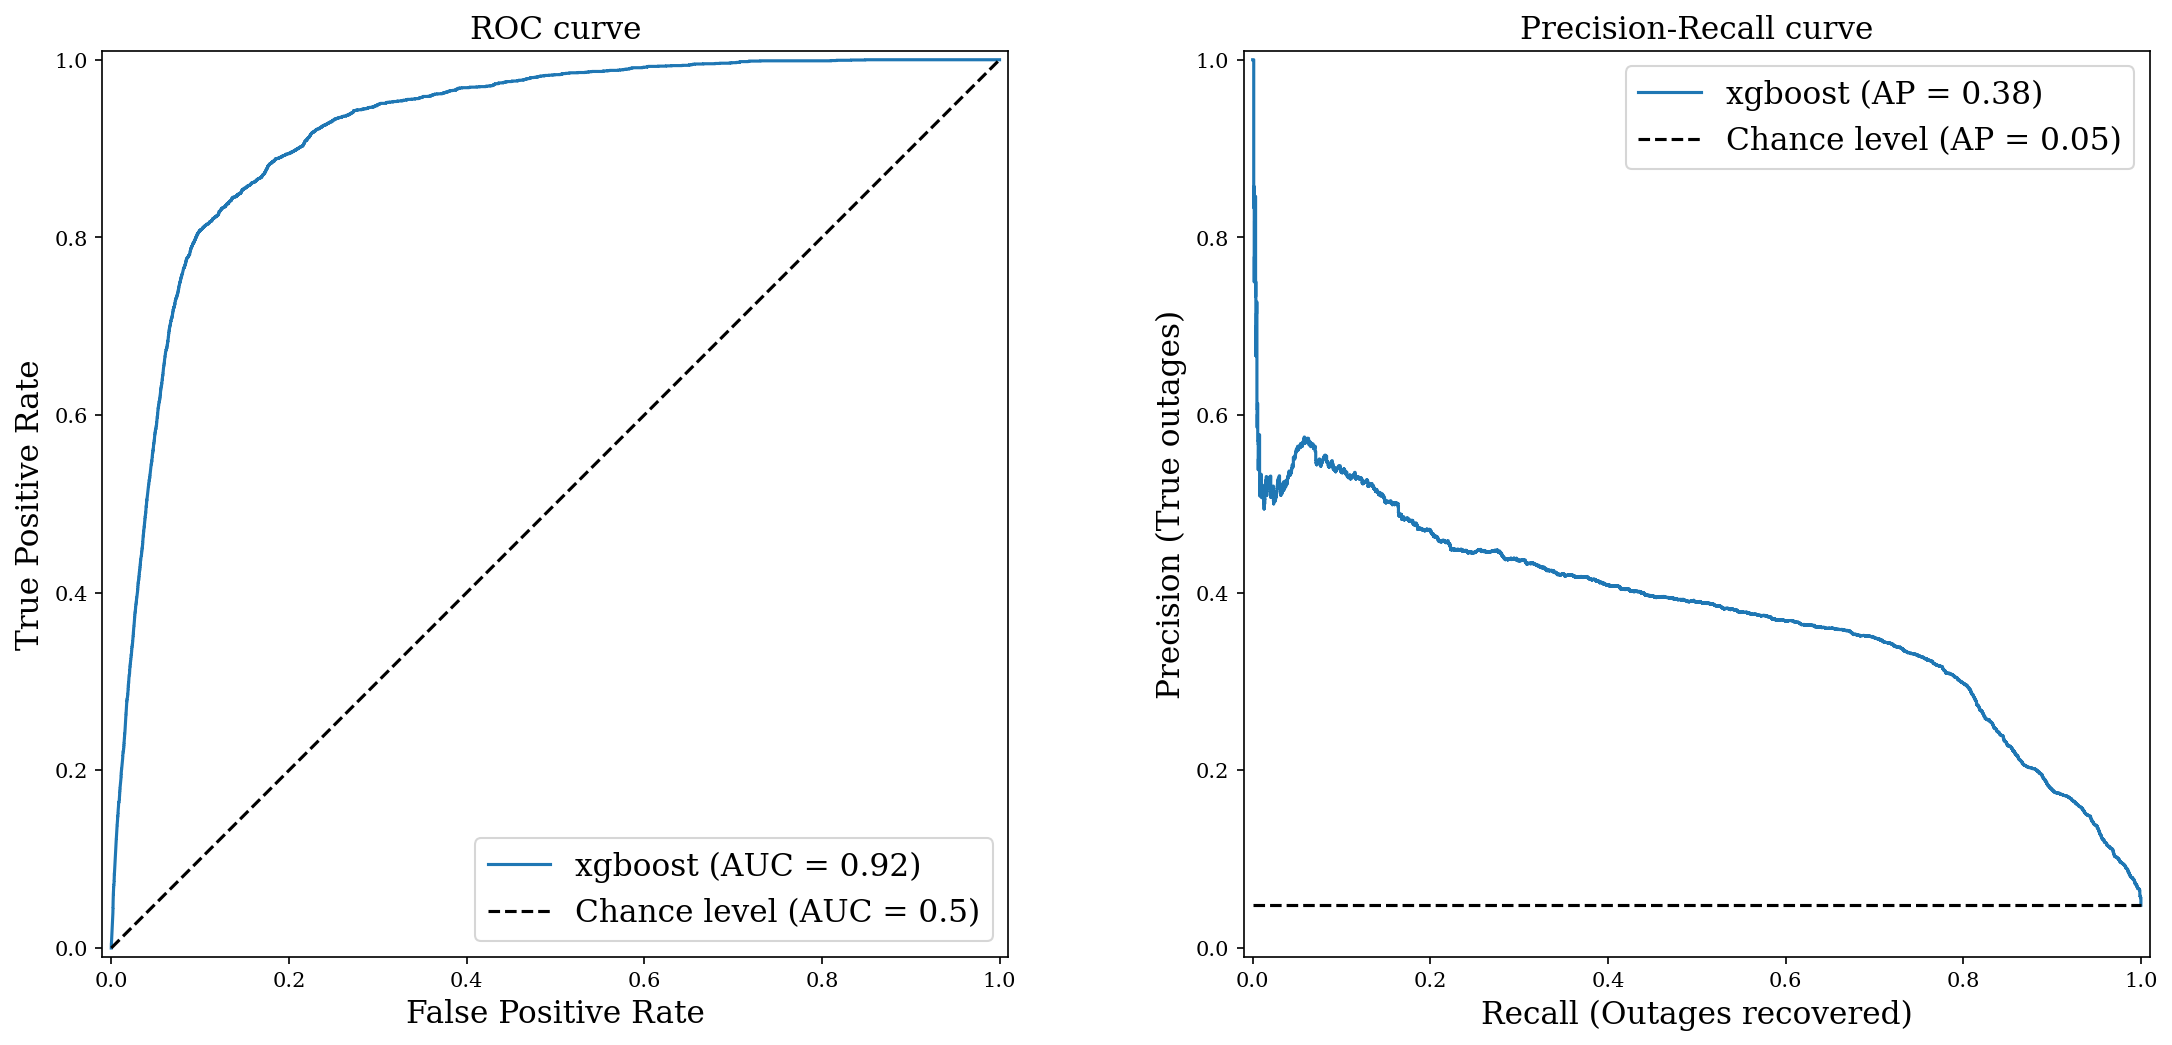

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
display = PrecisionRecallDisplay.from_estimator(
        best_model, tor_test[features_n], tor_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[1], name='xgboost')
display2 = RocCurveDisplay.from_estimator(
        best_model, tor_test[features_n], tor_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[0], name='xgboost')

_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/tornado_roc_pr_test_results.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)

# Feature importance

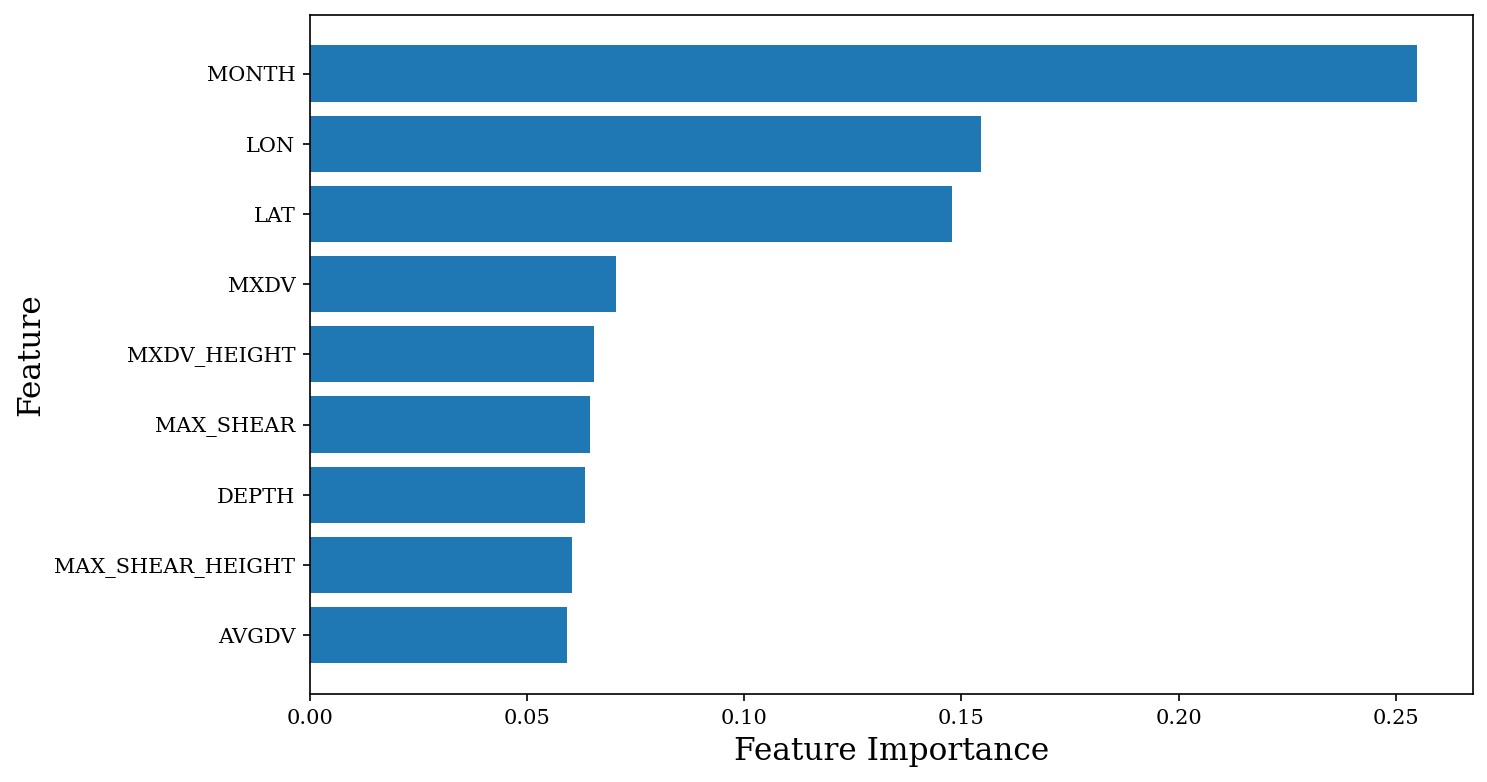

In [51]:
def plot_feature_importance(model, feature_names, top_n=10):
    # Get feature importance scores from the model
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importance = importance[indices]
    

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), sorted_importance, align='center')
    plt.yticks(range(len(indices)), sorted_feature_names)
    plt.xlabel('Feature Importance', size=15)
    plt.ylabel('Feature', size=15)
    #plt.title('Feature Importance', size=15)
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.savefig("../../figures/tornado_feature_importance.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)
    plt.show()
plot_feature_importance(best_model['clf'], features_n, top_n=9)

In [47]:
best_model['clf'].feature_importances_

array([0.2549513 , 0.14784212, 0.1546146 , 0.05922446, 0.05908126,
       0.07049223, 0.0654519 , 0.06339007, 0.06454284, 0.06040922],
      dtype=float32)

# Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

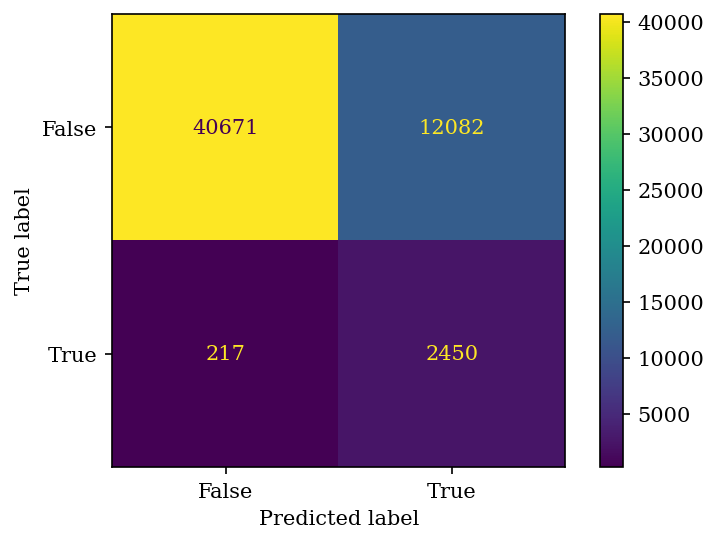

In [96]:
ConfusionMatrixDisplay.from_predictions(tor_val['power_outage'], predictions['xgboost'])

# Confusion matrix with a different threshold

In [53]:
probas = best_model.predict_proba(tor_test[features_n])

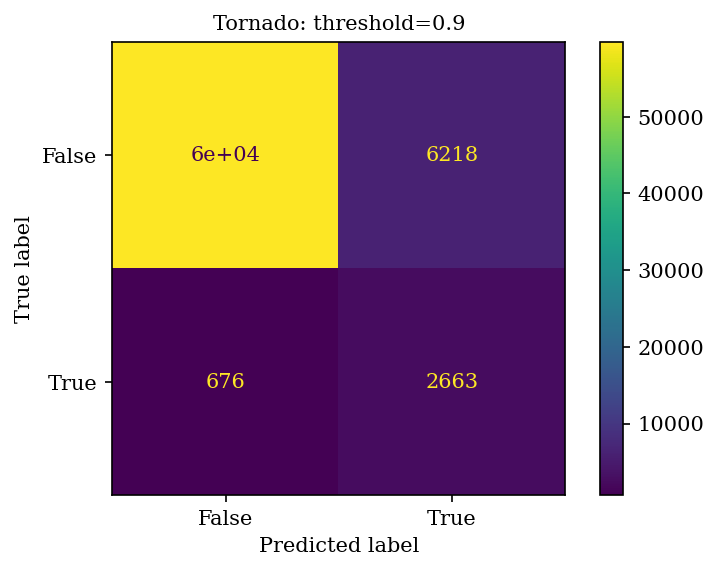

In [60]:
thr = 0.9
display = ConfusionMatrixDisplay.from_predictions(tor_test['POWER_OUTAGE'], probas[:,1]>thr)
_ = display.ax_.set_title("Tornado: threshold={}".format(thr), size=10)      
plt.savefig("../../figures/tornado_confusion_matrix_thr_{:1.0f}.png".format(10*thr), dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)